# Basic example of Analyzer use and functions

In [1]:
# For development purposes, reload imported modules when source changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
import numpy as np
import neo
from os.path import join
import yaml
import quantities as pq
import matplotlib.pylab as plt

### Create specific input and output extractors

In [3]:
from InputExtractor import InputExtractor
from OutputExtractor import OutputExtractor

class MEArecInputExtractor(InputExtractor):
    def __init__(self, recording_folder):
        InputExtractor.__init__(self)
        self.implemented_get_raw_slices = True
        self.implemented_get_probe_information = True
        self.recording_folder = recording_folder
        self.fs = None
        self.positions = None
        
    def extractRawSlices(self, t_start=None, t_end=None, electrode_ids=None):
        recordings, times, positions, templates, spiketrains, sources, peaks, info = \
        load_recordings(self.recording_folder)
        return recordings, times
    
    def getSamplingFrequency(self):
        if self.fs is None:
            recordings, times, positions, templates, spiketrains, sources, peaks, info = \
            load_recordings(self.recording_folder)
            self.fs  =info['General']['fs']
        return self.fs * pq.kHz
    
    def getProbeInformation(self):
        if self.positions is None:
            recordings, times, positions, templates, spiketrains, sources, peaks, info = \
            load_recordings(self.recording_folder)
            self.positions = positions
        return self.positions
    

class MEArecOutputExtractor(OutputExtractor):
    def __init__(self, recording_folder):
        OutputExtractor.__init__(self)
        self.implemented_get_num_units = True
        self.implemented_get_unit_spike_times = True
        self.recording_folder = recording_folder
        self.numUnits = None
        
    def getNumUnits(self):
        if self.numUnits is None:
            recordings, times, positions, templates, spiketrains, sources, peaks, info = \
            load_recordings(self.recording_folder)
            self.numUnits = len(spiketrains)
        return self.numUnits            
        

    def getUnitSpikeTimes(self, unit_id, t_start=None, t_stop=None):
        spiketrains = np.load(os.path.join(self.recording_folder, 'spiketrains.npy'))
        return spiketrains[unit_id].times       
        
        
        
def load_recordings(recording_folder):
    '''
    Load generated recordings (from template_gen.py)

    Parameters
    ----------
    recording_folder: recordings folder

    Returns
    -------
    recordings, times, positions, templates, spiketrains, sources, peaks - np.arrays
    info - dict

    '''
    print("Loading recordings...")

    recordings = np.load(join(recording_folder, 'recordings.npy'))
    positions = np.load(join(recording_folder, 'positions.npy'))
    times = np.load(join(recording_folder, 'times.npy'))
    templates = np.load(join(recording_folder, 'templates.npy'))
    spiketrains = np.load(join(recording_folder, 'spiketrains.npy'))
    sources = np.load(join(recording_folder, 'sources.npy'))
    peaks = np.load(join(recording_folder, 'peaks.npy'))

    with open(join(recording_folder, 'info.yaml'), 'r') as f:
        info = yaml.load(f)

    if not isinstance(times, pq.Quantity):
        times = times * pq.ms

    print("Done loading recordings...")
    return recordings, times, positions, templates, spiketrains, sources, peaks, info

### Define local recording folder

In [4]:
rec_folder = '/home/alessio/Documents/Codes/MEArec/recordings/recordings_20cells_Neuronexus-32_10.0_10.0uV_21-09-2018:10:17'

Instantiate Input and Output Extractors for MEArec recordings

In [5]:
input_ext = MEArecInputExtractor(rec_folder)
output_ext = MEArecOutputExtractor(rec_folder)

Create Analyzer object

In [6]:
from Analyzer import Analyzer
analyze = Analyzer(input_ext, output_ext)

### Get NEO spiketrains

In [7]:
analyze.getSpikeTrain(1)[0]

SpikeTrain

In [8]:
neost = analyze.getSpikeTrain()
neost[0]

Loading recordings...
Done loading recordings...


SpikeTrain

In [25]:
wf = analyze.getUnitSpikeWaveforms(1)
print(wf.shape)

Loading recordings...
Done loading recordings...
('Number of waveforms: ', 41)
(41, 32, 192)


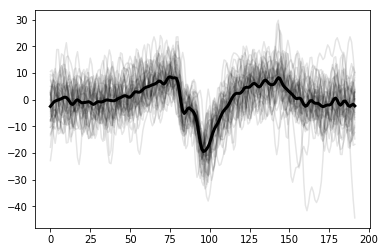

In [24]:
plt.plot(wf[:, 8].T, 'k', alpha=0.1)
plt.plot(wf[:, 8].mean(axis=0), 'k', lw=3)

In [27]:
# TODO extracte multiple spike waveforms at once